# Week 6: NLP use-cases
This notebook accompanies the week 6 lecture.  This week focuses on a set of interesting use-cases in NLP using the techniques we've covered in class

In [236]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import pickle

required = {'spacy', 'transformers'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import json
import numpy as np
import pandas as pd
import spacy
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import torch
import transformers
# this will set the device on which to train
#device = torch.device("cpu")
# if using collab, set your runtime to use GPU and use the line below
#device = torch.device("cuda:0")

## Unsupervised use-case: Movie genre "clusters"
Though we've dealt with several labelled datasets in our class, for the most part you will not have the advantage of labels on your dataset.  However, with the techniques we've covered, we can create informative groupings that may provide answers to some questions or facilitate labeling.

In [132]:
# read in movie descriptions from spoilers dataset
movies = pd.read_pickle('../data/spoilers_movies.pkl.gz')

# format a genre dataset, which will allow us to see how well our approach approximates the labelling
genres = np.unique(np.concatenate(movies.genre.values))
genre_dummies = np.zeros(shape=(len(movies), len(genres)))
for i, r in enumerate(movies.genre):
    for ii, g in enumerate(genres):
        if g in r:
            genre_dummies[i, ii] = 1
df_genre_dummies = pd.DataFrame(genre_dummies,
                               columns=genres,
                               index=movies.movie_id)

### Exercise: Choose a technique to process movie plot summaries
Think about some of the techniques we've already used (e.g. TFIDF, NMF, GloVe embeddings) and choose one for turning the raw summary text into a vector of information

In [50]:
# run word counts - TFIDF
tfidf = TfidfVectorizer(min_df=0.01, stop_words='english')
tfidf_vecs = tfidf.fit_transform(movies.plot_summary)

# examine sets of particularly "informative" words (i.e. high TF, low DF)
tfidf_df = pd.DataFrame(tfidf_vecs.toarray(),
            columns=tfidf.get_feature_names())
# what's the highest-weighted per movie, look at the top 10
tfidf_df.idxmax(axis=1).value_counts()[:10]

sam        2
gerry      2
angels     2
fbi        2
frank      2
beloved    2
peter      2
alien      2
king       2
gordon     2
dtype: int64

In [58]:
# alien seems pretty distinctive.  I imagine anything that has "alien" is probably sci-fi
movies[movies.plot_summary.str.find('alien')>-1]

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
1550,tt0103644,After escaping with Newt and Hicks from the mo...,1h 54min,"[Action, Horror, Sci-Fi]",6.4,1992-05-22,"In the movie's opening credits, the Sulaco, th..."
745,tt0120201,In the distant future high school kids are enc...,2h 9min,"[Action, Adventure, Sci-Fi]",7.2,1997-11-07,"In the distant future, several hundred years a..."
237,tt0115571,"Zane (Charlie Sheen), a young, mild-mannered a...",1h 55min,"[Sci-Fi, Thriller]",6.3,1996-05-31,"Zane Zaminski (Charlie Sheen), a radio astrono..."


In [107]:
# but a better measure here is comparing vectors
tfidf_sim = cosine_similarity(tfidf_df)
random_idx = np.random.randint(len(tfidf_sim))
# take the most similar for this random idx (aside from self)
movies.iloc[[random_idx,
            tfidf_sim[random_idx].argsort()[-2]]].plot_summary.values
# not clear if this is working, just pairwisw

array(["Tommy Callahan Jr. is a slow-witted, clumsy guy who recently graduated college after attending for seven years. His father, Big Tom Callahan, owns an auto parts factory in Ohio. When Tommy arrives back home, he finds he has a position at the factory waiting for him. His dad also introduces Tommy to the new brake pad division of the factory and to Tommy's soon-to-be stepmother, Beverly, and her son Paul. But when Big Tom dies, the factory threatens to go under unless the new brake pads are to be sold. Therefore, Tommy must go on the road to sell them, along with the assistance of Richard, Big Tom's right-hand man. Will Tommy save the company, or will the factory, and the town, go under?                Written by\nAnonymous",
       'New York based jazz pianist Willie Conway heads back to his small hometown of Knights Ridge, Massachusetts for a high school reunion. The trip is as much to go to the reunion and see his old friends - none of whom left Knights Ridge after graduation 

In [69]:
# run topic model - NMF
n_components = 10
nmf = NMF(n_components=n_components)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

# examine topic model
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))
display_components(nmf, tfidf.get_feature_names())


Topic 0:
family man decides home frank
Topic 1:
luke han princess leia skywalker
Topic 2:
life year love old sam
Topic 3:
ed mindspring esutton sutton man
Topic 4:
king porthos athos artagnan aramis
Topic 5:
movie follows film new building
Topic 6:
war general attack army force
Topic 7:
bond max jhailey cady hotmail
Topic 8:
school high friends girl hero
Topic 9:
gordon team hockey coach win


In [66]:
# i'd imagine  loading on 1 = star wars
movies.iloc[np.argsort(nmf_vecs[:, 1])[-5:]].plot_summary.values

array(["12-year-old Dre Parker has moved to China, and finds himself like a fish out of water. He befriends a fellow classmate, Mei Ying, only to make a rival, Cheng, who starts to bully and attack Dre. Soon, Mr Han, the maintenance man of Dre's apartment, fends off Cheng and his friends when they are attacking Dre and signs Dre up to fight in the Kung Fu tournament in return for the bullies laying off of Dre. Dre realizes Mr. Han is much more than a maintenance man, when he's revealed as a master of Kung Fu and Dre soon learns that Kung Fu is about self defense and peace, instead of violence and bloodshed.                Written by\nKennedy",
       'As the Clone Wars sweep through the galaxy, the heroic Jedi Knights struggle to maintain order and restore peace. More and more systems are falling prey to the forces of the dark side as the Galactic Republic slips further and further under the sway of the Separatists and their never-ending droid army. Anakin Skywalker and his Padawan lea

In [110]:
# with similarity
nmf_sim = cosine_similarity(nmf_vecs)
random_idx = np.random.randint(len(nmf_sim))
# take the most similar for this random idx (aside from self)
movies.iloc[[random_idx,
            nmf_sim[random_idx].argsort()[-2]]].plot_summary.values
# not clear if this is working, just pairwisw

array(["Luke Skywalker, Han Solo, Princess Leia and Chewbacca face attack by the Imperial forces and its AT-AT walkers on the ice planet Hoth. While Han and Leia escape in the Millennium Falcon, Luke travels to Dagobah in search of Yoda. Only with the Jedi master's help will Luke survive when the dark side of the Force beckons him into the ultimate duel with Darth Vader.                Written by\nJwelch5742",
       'The Imperial Forces, under orders from cruel Darth Vader, hold Princess Leia hostage in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker and Han Solo, captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 and C-3PO to rescue the beautiful princess, help the Rebel Alliance and restore freedom and justice to the Galaxy.                Written by\nJwelch5742'],
      dtype=object)

So far we've been looking at different slices of these models/heuristics.  But the purpose, as we've covered before, is to go from unstructured text and a lot of noise, to distilled representations.  In SVM models, we used the representations as input and trained weights on each dimension.  In clustering, we'll be embedding our text in "representation space" and grouping those representations.

The method we're using here is called K-Means clustering.  Refer to the slides for an explanation.  Suffice to say here, it's a fairly simple method for creating those groups.

In [141]:
# clustering K-means
clusterer = KMeans(n_clusters=5)
clusterer.fit(nmf_vecs)
cluster_preds = clusterer.predict(nmf_vecs)

# how well did our clustering do
print('Inertia (Sum of squared distances to cluster center):', clusterer.inertia_)

Inertia (Sum of squared distances to cluster center): 7.561936280646607


In [181]:
# how are these clusters split by genre
# just subseting to our top 5 genres, for ease of viewing
top_genres = df_genre_dummies.sum().nlargest(n=5).index.tolist()
cluster_by_genre = df_genre_dummies[top_genres].groupby(cluster_preds).sum()
cluster_by_genre
# seems like we're seeing a lot in one cluster, yikes!

,Drama,Comedy,Adventure,Action,Crime
0,7.0,3.0,4.0,4.0,2.0
1,77.0,52.0,39.0,35.0,34.0
2,2.0,1.0,2.0,2.0,2.0
3,0.0,0.0,3.0,3.0,0.0
4,0.0,1.0,3.0,3.0,0.0


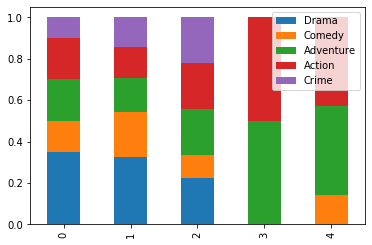

In [194]:
# get the % of each cluster in each genre
cluster_by_genre.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True)

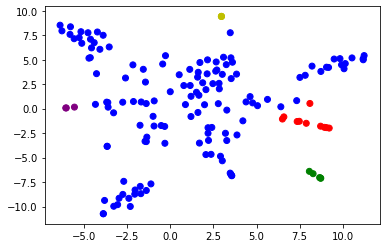

In [165]:
# one way to visualize this: a two-dimensional decomposition (T-SNE)
# see https://scikit-learn.org/stable/modules/manifold.html#t-sne for more info
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# fitting to 2 components
tsne_decomposition = TSNE(n_components=2, random_state=42).fit_transform(nmf_vecs)
fig, ax = plt.subplots()
# colors based on clusters
color_cycle = ['r', 'b', 'g', 'y', 'purple']
ax.scatter(tsne_decomposition[:,0], tsne_decomposition[:,1],
          c=[color_cycle[c] for c in cluster_preds])

### Exercise: Experiment with clustering
We've tried out a specific use of KMeans with a specific set of features, but there are tons of other ways to approach this.  Spend some time experimenting with different KMeans parameters and using other sets of features.  

Some example experiments:
- Tuning the number of clusters based on lowest inertia
- Fitting clusters to vectors of spatial information (e.g. cosine similarity)
- Trying other featuresets (e.g. TFIDF)

See if you can find a solution where the clusters seem to map on to genres to some extent, or at least where we don't see these big clusters.

## Named-Entity Recognition
The use-case we'll be covering in the slides might be considered "semi-supervised".  In a lot of cases, you may have an inventory of named-entities, but not necessary a fully labelled set of text.  In this use-case, we'll use our movie  dataset and a simple pattern matching implemented in SpaCy to train a NER model from scratch to recognize locations and actors.

In [203]:
from spacy.matcher import Matcher, PhraseMatcher

In [235]:
# read in movie descriptions from spoilers dataset
movies = pd.read_pickle('../data/spoilers_movies.pkl.gz')
# an inventory of 288 academy award nominated actors 
actor_inventory = pickle.load(open('../data/actors_inventory.pkl', 'rb'))
# a set of 150 US cities
city_inventory = pickle.load(open('../data/city_inventory.pkl', 'rb'))

In [252]:
# how to use spaCy's PhraseMatcher
# adapted from https://spacy.io/usage/rule-based-matching#phrasematcher
# load a language model
from spacy.lang.en import English
en = English()
matcher = PhraseMatcher(en.vocab)
inventories = {'people': ["Barack Obama", "Angela Merkel"],
           'locations': ["Washington, D.C.", "Oval Office"]}
for k in inventories:           
    matcher.add(k, # label for the match 
                None, # no custom function for dealing with matches ("callback")
                *[en(text) for text in inventories[k]])

doc = en("German Chancellor Angela Merkel and US President Barack Obama "
          "converse in the Oval Office inside the White House in Washington, D.C.")
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    # note: match_id is stored as an index within the vocab
    print(match_id, en.vocab[match_id].text, span.text)

7593739049417968140 people Angela Merkel
7593739049417968140 people Barack Obama
13063876858105367867 locations Oval Office
13063876858105367867 locations Washington, D.C.


### Exercise: Create 

In [ ]:
# this code is for subsetting, you don't need to run this
# read in full data
movies = pd.read_json(
    open('../data/imdb-spoiler-dataset/IMDB_movie_details.json'),
    lines=True)
reviews = pd.read_json(
    open('../data/imdb-spoiler-dataset/IMDB_reviews.json'),
    lines=True)
# subset
random_state = 42
samp_movies = movies.sample(frac=.1, random_state=random_state)
samp_reviews = reviews[reviews.movie_id.isin(samp_movies.movie_id)]

# output for analysis
samp_movies.to_pickle('../data/spoilers_movies.pkl.gz')
samp_reviews.to_pickle('../data/spoilers_reviews.pkl.gz')

In [ ]:
# read in data
movies = pd.read_pickle('./spoilers_movies.pkl.gz')
reviews = pd.read_pickle('./spoilers_reviews.pkl.gz')

In [ ]:
# some general EDA
print(movies.info())
print(reviews.info())
# descriptives of review text
print(reviews.review_text.apply(len).describe())
# what's our class distribution
print(reviews.is_spoiler.value_counts())

#### How can we identify whether a review is likely to be a spoiler?
Let's refer to the [ML project requirements](https://www.jeremyjordan.me/ml-requirements/) article and see if we can evaluate this dataset for its potential to answer that question.

Some questions we might want to ask:
- Who is the user of this product?
- What data might we need?
- What data/features do we have to work with?
- Is the a simple heuristic here that might be preferable over a model?
- How can we iterate here and find improvement?
- What is the benefit from getting more elaborate with our design? What is the cost?

We're lucky because we have a dataset tailored to this problem.  So let's focus on how we can identify spoilers with a minimal approach before even looking into models.

In [ ]:
# What about a coin-flip? 50/50 chance a review is a spoiler
actual = reviews.is_spoiler
pred = np.random.random(size=len(actual))<=0.5
accuracy_score(actual, pred)

In [ ]:
# what if we adjusted our coin flip by genre?
# are certain genres more likely to have spoilers?
# genre is a list of variable length, so we need to expand that
genres = np.unique(np.concatenate(movies.genre.values))
genre_dummies = np.zeros(shape=(len(movies), len(genres)))
for i, r in enumerate(movies.genre):
    for ii, g in enumerate(genres):
        if g in r:
            genre_dummies[i, ii] = 1
df_genre_dummies = pd.DataFrame(genre_dummies,
                               columns=genres,
                               index=movies.movie_id)
reviews_genre = df_genre_dummies.merge(reviews[['movie_id', 'is_spoiler']],
                      left_index=True, right_on='movie_id')
# now we have the count of spoilers and non spoilers, by genre
genre_spoiler = reviews_genre.groupby('is_spoiler').sum().T
genre_spoiler

In [ ]:
# so what if we just set our prediction to the average spoiler prob of genres?
genre_spoiler_prob = genre_spoiler[True]/genre_spoiler.sum(axis=1)
# just getting this at the movie level
movie_spoiler_prob = movies.genre.apply(lambda x: genre_spoiler_prob.loc[x].mean())
movie_spoiler_prob.index = movies.movie_id
actual = reviews.is_spoiler
pred = np.random.random(size=len(actual))
pred = pred <= reviews.movie_id.apply(lambda x: movie_spoiler_prob.loc[x])
accuracy_score(actual, pred)
# what's the problem with this prediction?

In [ ]:
# train/val/test construction
# what are the considerations for constructing?
np.random.seed(seed=42)
# Will use 70/15/15 train/validation/test
pct_train = 0.7
pct_val = 0.15
pct_test = 1-pct_train-pct_val
draws = np.random.random(len(reviews))
train_bool = draws<=pct_train
val_bool = (draws>pct_train)&(draws<=pct_train+pct_val)
test_bool = (draws>pct_train+pct_val)&(draws<=pct_train+pct_val+pct_test)
train = reviews[train_bool]
val = reviews[val_bool]
test = reviews[test_bool]
print(train.shape, val.shape, test.shape)

In [ ]:
# try the above method, but considering fitting on train
train_spoiler_prob = reviews_genre[train_bool].groupby('is_spoiler').sum().T
train_spoiler_prob = train_spoiler_prob[True]/train_spoiler_prob.sum(axis=1)
movie_spoiler_prob = movies.genre.apply(lambda x: train_spoiler_prob.loc[x].mean())
movie_spoiler_prob.index = movies.movie_id
for d in [train, val]:
    actual = d.is_spoiler
    pred = np.random.random(size=len(actual))
    pred = pred <= d.movie_id.apply(lambda x: movie_spoiler_prob.loc[x])
    print(accuracy_score(actual, pred))

In [ ]:
# now we're getting into models
# how does a simple word count+SVM perform?
tfidf = TfidfVectorizer(lowercase=False, min_df=0.01)
svc = LinearSVC()
tfidf_train = tfidf.fit_transform(train.review_text)
print(tfidf_train.shape)
svc.fit(tfidf_train, train.is_spoiler)
for d in [train, val]:
    actual = d.is_spoiler
    pred = svc.predict(tfidf.transform(d.review_text))
    print(accuracy_score(actual, pred))

In [ ]:
# what about topic models?
n_components = 10
nmf = NMF(n_components=n_components)
nmf_train = nmf.fit_transform(tfidf_train)
svc.fit(nmf_train, train.is_spoiler)
for d in [train, val]:
    actual = d.is_spoiler
    pred = svc.predict(
        nmf.transform(
            tfidf.transform(d.review_text)))
    print(accuracy_score(actual, pred))


In [ ]:
# what is our information inventory?
# what text info do we have from movies?
print(movies.filter(regex='plot').applymap(lambda x: len(x)).describe())
# what if we include movie information?
# using summary, which is a bit more concise
tfidf_movies = pd.DataFrame(tfidf.transform(movies.plot_summary).toarray(),
                            index=movies.movie_id)
# shape to fit base dataset
movie_features = train.merge(
    tfidf_movies, left_on='movie_id', right_index=True)[tfidf_movies.columns]

In [ ]:
# concatenate the two arrays
train_feats = np.concatenate([tfidf_train.toarray(),
                              movie_features.values], axis=1)
svc.fit(train_feats, train.is_spoiler)
for d in [train, val]:
    actual = d.is_spoiler
    movie_feats = d.merge(
        tfidf_movies, left_on='movie_id', right_index=True)[tfidf_movies.columns].values
    tfidf_feats = tfidf.transform(d.review_text).toarray()
    pred = svc.predict(
        np.concatenate([tfidf_feats, 
                        movie_feats], axis=1))
    print(accuracy_score(actual, pred))

#### Exploring pre-trained models
Now that we have a simple, performant baseline, here's where we might want to bring in some pre-trained models.  Or, maybe adapt these pre-trained models via a process called fine-tuning. 

Let's start by exploring some available models and their outputs.

In [ ]:
# what we're used to: BERT
from transformers import BertTokenizer, BertModel 
MODEL_NAME = 'bert-base-uncased'
# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# what probably makes more sense to use in this setting
from transformers import DistilBertModel, DistilBertTokenizer
MODEL_NAME = 'distilbert-base-uncased'
# Load pre-trained model
distil_model = DistilBertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
distil_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
%%time
# one dimension of difference: speed
samp_reviews = reviews['review_text'].sample(frac=0.001)
tokens = tokenizer.batch_encode_plus(samp_reviews,
  pad_to_max_length=True, return_tensors="pt", 
  max_length=512) # BERT expects sequences of 512 tokens
outputs = model(**tokens)

In [ ]:
%%time
samp_reviews = reviews['review_text'].sample(frac=0.01)
tokens = distil_tokenizer.batch_encode_plus(samp_reviews,
  pad_to_max_length=True, return_tensors="pt", 
  max_length=512) # BERT expects sequences of 512 tokens
distil_outputs = distil_model(**tokens)

We can see here the difference between some of the models out there.  Some will take many hours to run our data through (if we can even do so without crashing the machine!).  BERT is not really designed for CPU work.  It's also not really designed to give document-level representations because it's trained on sentences.

Luckily, on Collaboratory, we get access to a GPU, which speeds things up a bit.

In [ ]:
# pass model to GPU
distil_model.to(device)

In [ ]:
# here we're doing small batches to the model on GPU, we'll load the product of this process later
# The model itself takes up a LOT of memory, so we're passing very small batches
# note here: You may run out of RAM if you try and run this along with all the above.
st = 0
batch_size = 5
batches = list(range(batch_size, len(reviews), batch_size))+[len(reviews)]
doc_rep_collector = []
for b in batches:
    tokens = distil_tokenizer.batch_encode_plus(
        reviews['review_text'][st:b],
        pad_to_max_length=True, 
        return_tensors="pt",
        max_length=512)
    st = b
    tokens.to(device)
    outputs = distil_model(**tokens)
    # taking the representation of the 'CLS' token (doc-level embedding)
    o = outputs[0][:,0].cpu().detach().numpy()
    doc_rep_collector.append(o)

# stack into array
doc_rep_collector = np.concatenate(doc_rep_collector)
# to minimize size, can store as 16-bit float
doc_rep_collector = doc_rep_collector.astype('float16')
# additionally, will store as gzip (pandas can handle this)
import gzip
pickle.dump(doc_rep_collector, gzip.open('review_bert_vectors.pkl.gz', 'wb'))

In [ ]:
# bringing this portion down here: often running out of RAM on standard runtimes
reviews = pd.read_pickle('../data/spoilers_reviews.pkl.gz')
np.random.seed(seed=42)
# Will use 70/15/15 train/validation/test
pct_train = 0.7
pct_val = 0.15
pct_test = 1-pct_train-pct_val
draws = np.random.random(len(reviews))
train_bool = draws<=pct_train
val_bool = (draws>pct_train)&(draws<=pct_train+pct_val)
test_bool = (draws>pct_train+pct_val)&(draws<=pct_train+pct_val+pct_test)
train = reviews[train_bool]
val = reviews[val_bool]
test = reviews[test_bool]
print(train.shape, val.shape, test.shape)

In [ ]:
# using BERT representations for prediction
bert_vectors = pd.read_pickle('../data/review_bert_vectors.pkl.gz')
print(bert_vectors.shape)

In [ ]:
svc = LinearSVC()
svc.fit(bert_vectors[train_bool], train.is_spoiler)
for b in [train_bool, val_bool]:
    actual = reviews[b].is_spoiler
    pred = svc.predict(bert_vectors[b])
    print(accuracy_score(actual, pred))

This is bonus, but SpaCy also has an implementation of transformers.  I haven't set it up on GPU, but feel free to try this out.  It gives you similar objects to those we're used to working with out of SpaCy.  However, it has some compatibility issues with the `transformers` library (specifically, it requires transformers 2.0).

In [ ]:
# this is what we might refer to as "tech debt"
# for spacy-transformers, you'll need a different version of transformers
!pip uninstall -y transformers
# after running this, you may need to restart the runtime/kernel
!python -m spacy download en_trf_distilbertbaseuncased_lg
# if running on collaboratory, you'll have to run these as well
!pip install spacy
!pip install spacy-transformers
# definitely makes sense to restart the runtime/kernel if you're running these

In [ ]:
import spacy
nlp = spacy.load("en_trf_distilbertbaseuncased_lg")

In [ ]:
%%time
samp_reviews = reviews['review_text'].sample(frac=0.001)
parsed = [nlp(doc) for doc in samp_reviews]

In the snippet below, I run the dataset iteratively through DistilBERT, retrieving the representation of the [CLS] token.  This takes a while to run, so we'll just be loading the product of that.

In [ ]:
st = 0
batch_size = 5
batches = list(range(batch_size, len(reviews), batch_size))+[len(reviews)]
doc_rep_collector = []
for b in batches:
    cls_rep = [nlp(x)._.trf_last_hidden_state[0] for x in reviews['review_text'][st:b]]
    st = b
    doc_rep_collector.append(cls_rep)

# stack into array
doc_rep_collector = np.concatenate(doc_rep_collector)
pickle.dump(doc_rep_collector, open('review_bert_vectors.pkl', 'wb'))